# **1. IMPORT LIBRARIES**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# **2. DATA LOADING**

In [5]:
df = pd.read_csv('/content/ToyotaCorolla - MLR.csv')
df.head()

,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


# **3. EXPLORATORY DATA ANALYSIS (EDA)**

**HISTOGRAM**

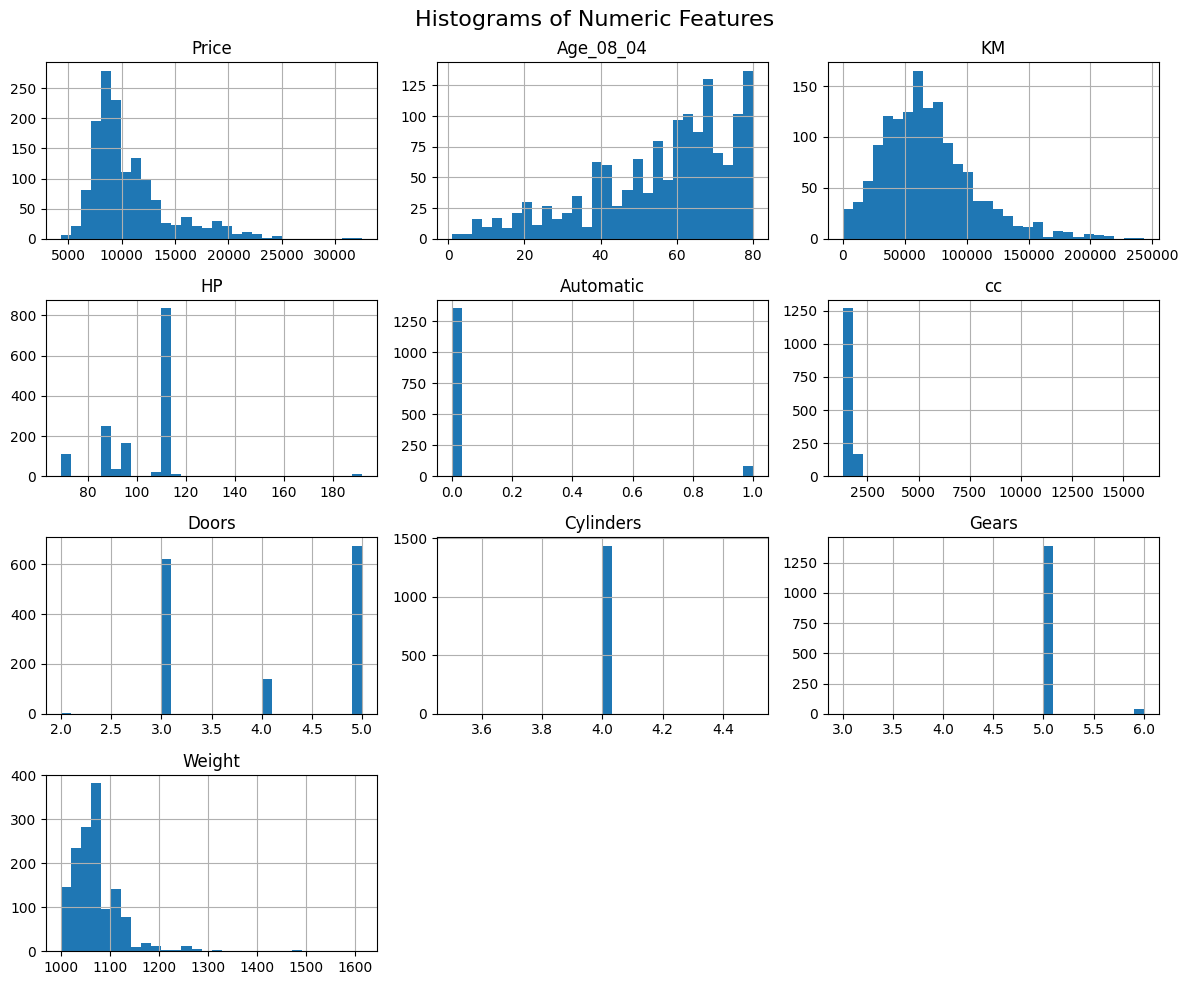

In [6]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_features].hist(figsize=(12, 10), bins=30)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

**BOXPLOT**

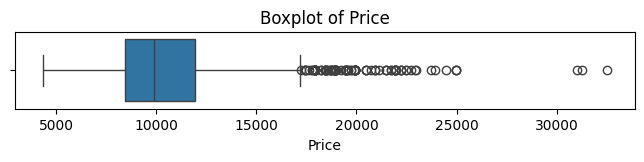

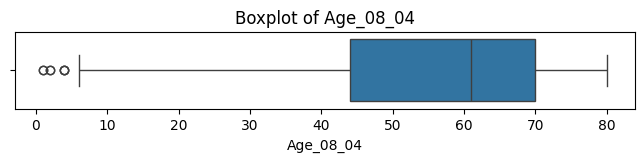

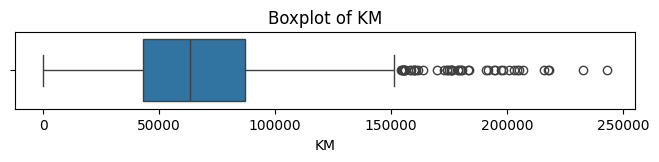

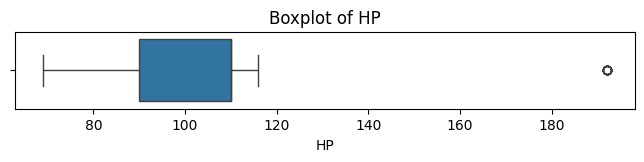

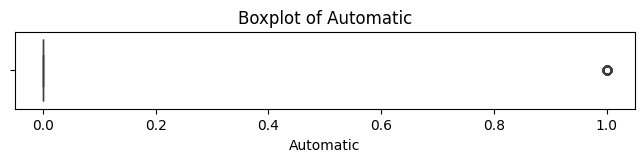

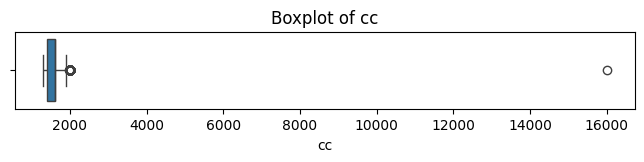

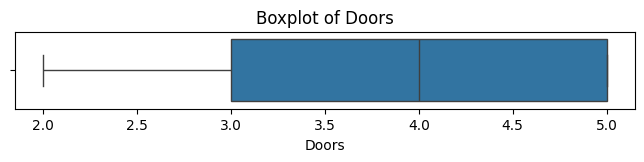

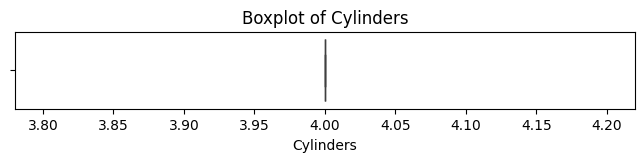

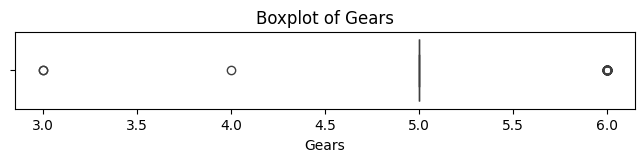

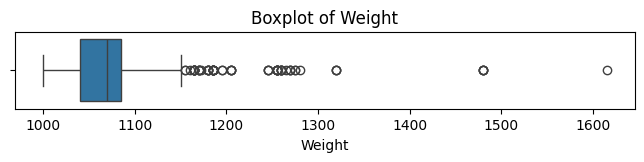

In [7]:
for column in numeric_features:
    plt.figure(figsize=(8, 1))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

**CORRELATION HEATMAP**

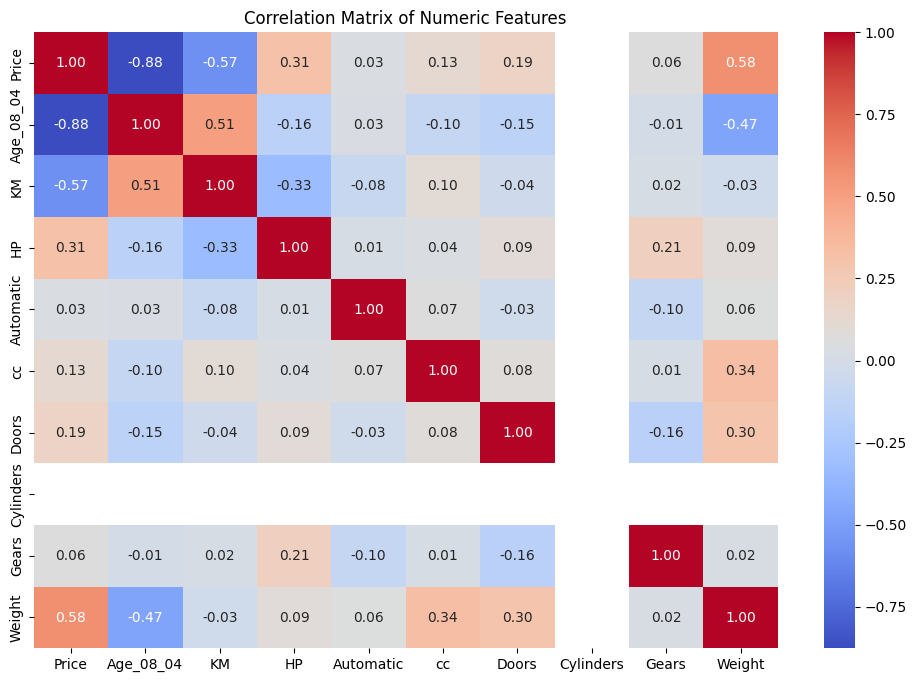

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

**PAIRPLOT OF SELECTED FEATURES**

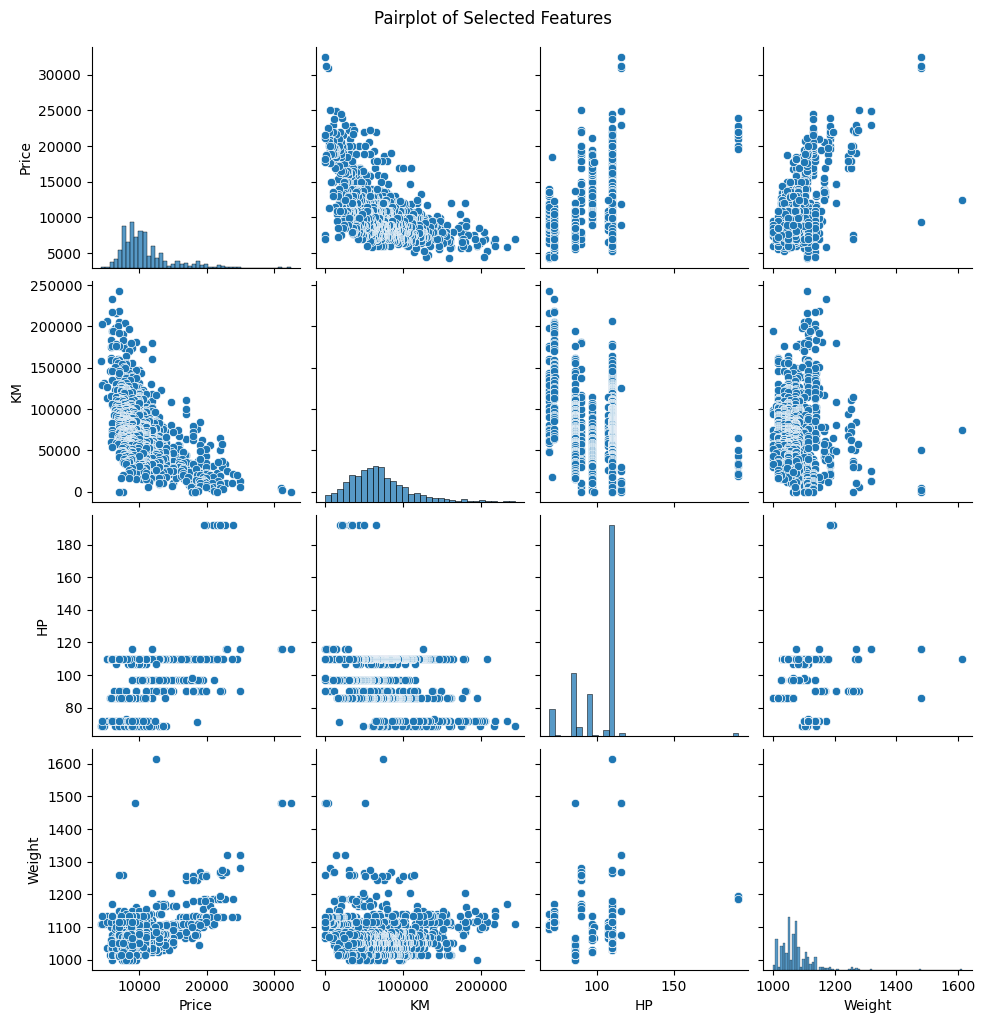

In [9]:
selected_columns = ['Price', 'Age', 'KM', 'HP', 'CC', 'Weight', 'Quarterly_Tax']
existing_columns = [col for col in selected_columns if col in df.columns]
sns.pairplot(df[existing_columns])
plt.suptitle("Pairplot of Selected Features", y=1.02)
plt.show()

# **4. OUTLIERS TREATMENT (IQR METHOD)**

In [10]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower_bound, lower_bound,
                          np.where(df[column] > upper_bound, upper_bound, df[column]))

for col in numeric_features:
    if col != 'Price':
        cap_outliers_iqr(df, col)

# **5. FEATURE AND TARGET SEPARATION**

In [11]:
X = df.drop('Price', axis=1)
y = df['Price']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# **6. FEATURE SELECTION**

**6.1 CORRELATION-BASED FEATURE SELECTION**

In [12]:
corr_matrix = df.corr(numeric_only=True)
high_corr_features = corr_matrix['Price'].abs().sort_values(ascending=False)
selected_features_corr = high_corr_features.index[1:6].tolist()  # Top 5 features excluding 'Price'

**6.2 VIF-Based Feature Selection**

In [13]:
# Drop constant columns
numeric_for_vif = X.select_dtypes(include=['int64', 'float64'])
numeric_for_vif = numeric_for_vif.loc[:, numeric_for_vif.nunique() > 1]

# Replace infs and NaNs
numeric_for_vif = numeric_for_vif.replace([np.inf, -np.inf], np.nan)
numeric_for_vif = numeric_for_vif.fillna(numeric_for_vif.mean())

# Add constant for VIF calculation
X_vif = add_constant(numeric_for_vif)

# Compute VIF
vif_data = pd.DataFrame({
    'Feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Drop 'const' from final list
vif_data = vif_data[vif_data['Feature'] != 'const']

# Select features with VIF < 10
selected_features_vif = vif_data[vif_data['VIF'] < 10]['Feature'].tolist()




## **6.3 MANUAL FEATURE SELECTION**

In [14]:
selected_features_manual = ['Age_08_04', 'KM', 'Weight', 'HP', 'Fuel_Type']


# **7. FUNCTION: Train and Evaluate Linear Model**

In [15]:
def train_and_evaluate_model(X, y, selected_features, model_name):
    """Trains and evaluates a Linear Regression model using selected features."""

    # Check for missing features
    missing_features = [feat for feat in selected_features if feat not in X.columns]
    if missing_features:
        print(f"\n{model_name} - Missing features: {missing_features} - Skipping this model.")
        return

    # Subset and preprocess
    X_subset = X[selected_features]
    numeric = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical = X_subset.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Train-test split and model fitting
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Extract feature names and coefficients
    onehot_feature_names = []
    if len(categorical) > 0:
        try:
            onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
            if hasattr(onehot, 'get_feature_names_out'):
                onehot_feature_names = onehot.get_feature_names_out(categorical)
        except:
            pass

    feature_names = list(numeric) + list(onehot_feature_names)
    coef = pipeline.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef}).sort_values(by='Coefficient', key=abs, ascending=False)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output results
    print(f"\n---- {model_name} ----")
    print("MSE:", mse)
    print("R²:", r2)
    print("\nTop Coefficients:\n", coef_df.head(10))



# **8. TRAIN AND EVALUATE THREE LINEAR REGRESSION MODELS**

In [ ]:

# ---- CALLING THE FUNCTION TO BUILD 3 MODELS ----
train_and_evaluate_model(X, y, selected_features_corr, "Model 1 - Correlation Based")
train_and_evaluate_model(X, y, selected_features_vif, "Model 2 - VIF Based")
train_and_evaluate_model(X, y, selected_features_manual, "Model 3 - Manual Selection")



---- Model 1 - Correlation Based ----
MSE: 2260721.2737454902
R²: 0.8305660607967559

Top Coefficients:
      Feature  Coefficient
0  Age_08_04 -2318.658526
2     Weight   857.761445
1         KM  -772.713657
3         HP   388.177692
4      Doors   -59.999142

---- Model 2 - VIF Based ----
MSE: 2232502.230024324
R²: 0.8326809892462521

Top Coefficients:
      Feature  Coefficient
0  Age_08_04 -2255.241407
5     Weight  1234.620680
1         KM  -668.900578
2         HP   474.829990
3         cc  -442.761248
4      Doors  -140.021622

---- Model 3 - Manual Selection ----
MSE: 2292099.6516283248
R²: 0.8282143502023365

Top Coefficients:
             Feature  Coefficient
0         Age_08_04 -2336.852610
2            Weight   898.570640
4     Fuel_Type_CNG  -773.001830
1                KM  -710.699556
6  Fuel_Type_Petrol   538.534385
3                HP   355.703508
5  Fuel_Type_Diesel   234.467445


# **9. FUNCTION: Train and Evaluate Regularized Model**

In [17]:
from sklearn.linear_model import Lasso, Ridge

def train_and_evaluate_regularized_model(X, y, selected_features, model_name, model_type):
    """Trains and evaluates a Lasso or Ridge regression model."""

    # Check for missing features
    missing_features = [feat for feat in selected_features if feat not in X.columns]
    if missing_features:
        print(f"\n{model_name} - Missing features: {missing_features} - Skipping this model.")
        return

    # Subset and preprocess
    X_subset = X[selected_features]
    numeric = X_subset.select_dtypes(include=['int64', 'float64']).columns
    categorical = X_subset.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
    ])

    # Choose model type
    if model_type == 'lasso':
        regressor = Lasso(alpha=1.0, max_iter=10000)
    elif model_type == 'ridge':
        regressor = Ridge(alpha=1.0)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])

    # Train-test split and model fitting
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Extract feature names and coefficients
    onehot_feature_names = []
    if len(categorical) > 0:
        try:
            onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
            if hasattr(onehot, 'get_feature_names_out'):
                onehot_feature_names = onehot.get_feature_names_out(categorical)
        except:
            pass

    feature_names = list(numeric) + list(onehot_feature_names)
    coef = pipeline.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef}).sort_values(by='Coefficient', key=abs, ascending=False)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Output results
    print(f"\n---- {model_name} ----")
    print("MSE:", mse)
    print("R²:", r2)
    print("\nTop Coefficients:\n", coef_df.head(10))


# **10. TRAIN AND EVALUATE LASSO AND RIDGE REGRESSION MODELS**

In [18]:
print("\n=== TRAINING REGULARIZED MODELS (LASSO & RIDGE) ===")
train_and_evaluate_regularized_model(X, y, selected_features_manual, "Model 4 - Lasso Regression", model_type='lasso')
train_and_evaluate_regularized_model(X, y, selected_features_manual, "Model 5 - Ridge Regression", model_type='ridge')



=== TRAINING REGULARIZED MODELS (LASSO & RIDGE) ===

---- Model 4 - Lasso Regression ----
MSE: 2291613.4521438545
R²: 0.8282507893223859

Top Coefficients:
             Feature  Coefficient
0         Age_08_04 -2336.065046
4     Fuel_Type_CNG  -940.627878
2            Weight   895.634125
1                KM  -712.742510
3                HP   354.910073
6  Fuel_Type_Petrol   296.128822
5  Fuel_Type_Diesel    -0.000000

---- Model 5 - Ridge Regression ----
MSE: 2292446.545029484
R²: 0.8281883516344791

Top Coefficients:
             Feature  Coefficient
0         Age_08_04 -2333.533085
2            Weight   898.849862
4     Fuel_Type_CNG  -740.979167
1                KM  -713.190279
6  Fuel_Type_Petrol   522.476621
3                HP   354.515891
5  Fuel_Type_Diesel   218.502546


# **9. INTERVIEW QUESTIONS**

In [19]:
# ==============================================
# Q1: What is Normalization & Standardization and how is it helpful?
# ==============================================

print("Q1: What is Normalization & Standardization and how is it helpful?\n")

print("Normalization and Standardization are techniques used to rescale data before training a machine learning model.")
print("These methods help ensure that all features contribute equally and improve the model's performance.")

print("\nNormalization:")
print("- Normalization (also called Min-Max Scaling) resizes all feature values to a fixed range, usually between 0 and 1.")
print("- It is useful when features have different units or scales.")
print("- Commonly used in distance-based algorithms like K-Nearest Neighbors and Neural Networks.")

print("\nStandardization:")
print("- Standardization (also known as Z-score scaling) transforms features so they have a mean of 0 and a standard deviation of 1.")
print("- It is especially helpful for algorithms like linear regression, logistic regression, and models with regularization.")
print("- Helps the model converge faster and treats each feature fairly.")

print("\nIn summary, both techniques are important for improving model performance, avoiding bias due to scale differences, and ensuring faster and more stable learning.")

# ==============================================
# Q2: What techniques can be used to address multicollinearity in multiple linear regression?
# ==============================================

print("\nQ2: What techniques can be used to address multicollinearity in multiple linear regression?\n")

print("Multicollinearity happens when two or more independent variables in a regression model are highly correlated.")
print("This can make the model unstable and make it hard to understand the impact of each variable.")
print("Here are some common techniques to handle multicollinearity:")

print("\n1. Variance Inflation Factor (VIF):")
print("- VIF tells us how much a variable is correlated with other variables.")
print("- A high VIF means strong multicollinearity. We can remove or combine such features.")

print("\n2. Correlation Matrix:")
print("- By checking the correlation between features, we can identify highly correlated pairs.")
print("- One of the correlated features can be dropped to reduce redundancy.")

print("\n3. Principal Component Analysis (PCA):")
print("- PCA is a technique that converts correlated features into a smaller number of uncorrelated ones.")
print("- This helps reduce multicollinearity while keeping most of the information.")

print("\n4. Regularization Methods (Ridge and Lasso):")
print("- Ridge regression adds a penalty to reduce the effect of multicollinearity by shrinking coefficients.")
print("- Lasso regression can even remove some features entirely by setting their coefficients to zero.")

print("\n5. Manual Feature Selection:")
print("- Based on data exploration or domain knowledge, we can manually remove or combine features.")

print("\nIn conclusion, handling multicollinearity is important for creating reliable, interpretable, and accurate regression models.")


Q1: What is Normalization & Standardization and how is it helpful?

Normalization and Standardization are techniques used to rescale data before training a machine learning model.
These methods help ensure that all features contribute equally and improve the model's performance.

Normalization:
- Normalization (also called Min-Max Scaling) resizes all feature values to a fixed range, usually between 0 and 1.
- It is useful when features have different units or scales.
- Commonly used in distance-based algorithms like K-Nearest Neighbors and Neural Networks.

Standardization:
- Standardization (also known as Z-score scaling) transforms features so they have a mean of 0 and a standard deviation of 1.
- It is especially helpful for algorithms like linear regression, logistic regression, and models with regularization.
- Helps the model converge faster and treats each feature fairly.

In summary, both techniques are important for improving model performance, avoiding bias due to scale diff